# AORTA FSDP2 Training Launcher

Use this notebook to orchestrate AORTA's multi-stream FSDP2 workload from a Jupyter session. It wraps the existing CLI so you can launch short sanity runs, full-scale multi-GPU jobs, and cross-accelerator experiments directly from the notebook interface.


## Workflow Overview

1. Run the setup cell to register the repository package path and inspect the active accelerator.
2. Adjust the configuration path or overrides to match the experiment you want to execute.
3. Invoke one of the helper functions:
   - `run_training_single_process(...)` for quick smoke tests on a single GPU or CPU inside the notebook kernel.
   - `run_training_torchrun(...)` to launch distributed jobs (NVIDIA/AMD) via `torchrun` while still streaming logs back into the notebook.
4. Optionally analyse the produced artefacts (logs, JSONL traces) with the reporting utilities once a run completes.

Each helper accepts the same CLI arguments as `train.py`, so you can reuse your existing YAML configs and override syntax.


In [7]:
# --- Environment bootstrap -------------------------------------------------
import os
import sys
import json
import shlex
import subprocess
from pathlib import Path

try:
    import torch
except ImportError:  # pragma: no cover - defensive fallback
    torch = None


def _find_repo_root(start: Path) -> Path:
    markers = [start] + list(start.parents)
    for candidate in markers:
        if (candidate / 'config' / 'default.yaml').exists():
            return candidate
        if (candidate / '.git').exists() and (candidate / 'src').exists():
            return candidate
    return start


REPO_ROOT = _find_repo_root(Path.cwd().resolve())
SRC_ROOT = REPO_ROOT / 'src'
if SRC_ROOT.exists() and str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

print(f"Repository root: {REPO_ROOT}")
print(f"Python executable: {sys.executable}")

if torch is None:
    print("PyTorch import failed; install torch before running training.")
else:
    accelerator = 'cpu'
    device_name = 'CPU'
    if torch.cuda.is_available():
        accelerator = 'nvidia'
        if getattr(torch.version, 'hip', None):
            accelerator = 'amd'
        try:
            device_name = torch.cuda.get_device_name(0)
        except Exception:  # pragma: no cover - query best effort
            device_name = 'Unknown GPU'
        device_count = torch.cuda.device_count()
    else:
        device_count = 0
    print(f"Detected accelerator: {accelerator} | device_count={device_count} | primary_device={device_name}")


Repository root: /manrao/jsr_perf_max/aorta
Python executable: /opt/conda/envs/py_3.10/bin/python
Detected accelerator: amd | device_count=8 | primary_device=AMD Instinct MI350X


In [8]:
import torch
torch.__version__

'2.8.0a0+git0bf8d8e'

## Inspect / Edit Configuration

The helpers expect a valid config file (default: `config/default.yaml`). Update the path or override dictionary in the next cell to customise hyperparameters, profiling options, or output directory for your run.


In [9]:

import yaml

CONFIG_PATH = REPO_ROOT / "config" / "default.yaml"
print(f"Using config: {CONFIG_PATH}")

with CONFIG_PATH.open("r", encoding="utf-8") as handle:
    base_config = yaml.safe_load(handle)

# Display the top-level keys for quick reference
print("Top-level config sections:", ", ".join(base_config.keys()))


Using config: /manrao/jsr_perf_max/aorta/config/default.yaml
Top-level config sections: logging, training, optimizer, scheduler, dataset, model, fsdp, compile, dataloader, profiling


## Training Launch Helpers

The functions below wrap `train.py` with robust environment setup and argument handling. They default to short runs (`max_steps=5`) to keep notebook executions lightweight—update or remove the overrides as needed for full-scale experiments.


In [12]:
import os
import shlex
import subprocess
import sys
from pathlib import Path
from typing import Mapping, Optional, Sequence, Union

if 'SRC_ROOT' not in globals():
    notebook_root = Path.cwd().resolve()
    guessed_src = notebook_root / 'src'
    SRC_ROOT = guessed_src if guessed_src.exists() else notebook_root
if 'CONFIG_PATH' not in globals():
    repo_root = Path.cwd().resolve()
    default_config = repo_root / 'config' / 'default.yaml'
    CONFIG_PATH = default_config if default_config.exists() else repo_root / 'config.yaml'


def _normalise_overrides(overrides: Optional[Union[Mapping[str, Union[str, int, float, bool]], Sequence[str]]]) -> Sequence[str]:
    """Convert override inputs into CLI-friendly dotted assignments."""

    if overrides is None:
        return []
    if isinstance(overrides, Mapping):
        items = []
        for key, value in overrides.items():
            if isinstance(value, bool):
                val_str = 'true' if value else 'false'
            else:
                val_str = str(value)
            items.append(f"{key}={val_str}")
        return sorted(items)
    return list(overrides)


def _prepare_env(extra_env: Optional[Mapping[str, str]] = None) -> dict[str, str]:
    env = os.environ.copy()
    pythonpath = env.get('PYTHONPATH', '')
    parts = [str(SRC_ROOT)] + ([pythonpath] if pythonpath else [])
    env['PYTHONPATH'] = os.pathsep.join(parts)
    if extra_env:
        env.update(extra_env)
    return env


def run_training_single_process(
    config_path: Union[str, Path] = CONFIG_PATH,
    overrides: Optional[Union[Mapping[str, Union[str, int, float, bool]], Sequence[str]]] = None,
    *,
    enable_rocm_metrics: bool = False,
    env: Optional[Mapping[str, str]] = None,
):
    """Execute `train.py` inside the notebook kernel using rank/world size = 1."""

    override_args = _normalise_overrides(overrides)
    cmd: list[str] = [sys.executable, '../train.py', '--config', str(config_path)]
    for item in override_args:
        cmd.extend(['--override', item])
    if enable_rocm_metrics:
        cmd.append('--enable-rocm-metrics')

    base_env = {
        'MASTER_ADDR': '127.0.0.1',
        'MASTER_PORT': os.environ.get('MASTER_PORT', '29500'),
        'RANK': '0',
        'WORLD_SIZE': '1',
        'LOCAL_RANK': '0',
    }

    complete_env = _prepare_env(base_env)
    if env:
        complete_env.update(env)

    print('Launching single-process training: ' + ' '.join(shlex.quote(token) for token in cmd))
    return subprocess.run(cmd, env=complete_env, check=False)


def run_training_torchrun(
    *,
    num_processes: int,
    config_path: Union[str, Path] = CONFIG_PATH,
    overrides: Optional[Union[Mapping[str, Union[str, int, float, bool]], Sequence[str]]] = None,
    enable_rocm_metrics: bool = False,
    extra_torchrun_args: Optional[Sequence[str]] = None,
    env: Optional[Mapping[str, str]] = None,
):
    """Launch distributed training via torchrun while streaming stdout/stderr into the notebook."""

    override_args = _normalise_overrides(overrides)
    cmd: list[str] = [
        'torchrun',
        '--standalone',
        '--nproc_per_node',
        str(num_processes),
    ]
    if extra_torchrun_args:
        cmd.extend(list(extra_torchrun_args))
    cmd.extend(['train.py', '--config', str(config_path)])
    for item in override_args:
        cmd.extend(['--override', item])
    if enable_rocm_metrics:
        cmd.append('--enable-rocm-metrics')

    complete_env = _prepare_env(env)

    print('Launching torchrun job: ' + ' '.join(shlex.quote(token) for token in cmd))
    return subprocess.run(cmd, env=complete_env, check=False)


## Example: Quick Smoke Test (Single GPU)

Uncomment or adjust the cell below to execute a short (5-step) run directly within the notebook. Increase `training.max_steps` or remove the overrides for longer profiling sessions.


In [13]:

# Example overrides tailored for a fast validation run.
quick_overrides = {
    "training.max_steps": 5,
    "training.log_interval": 1,
    "training.output_dir": "notebook_artifacts",
}

# Set `run = True` when you're ready to launch.
run = True

if run:
    result = run_training_single_process(
        overrides=quick_overrides,
        enable_rocm_metrics=False,
    )
    print(f"Process exited with return code {result.returncode}")
else:
    print("Set `run = True` to kick off the sample training run.")


Launching single-process training: /opt/conda/envs/py_3.10/bin/python ../train.py --config /manrao/jsr_perf_max/aorta/config/default.yaml --override training.log_interval=1 --override training.max_steps=5 --override training.output_dir=notebook_artifacts


2025-09-30 22:57:58,424 | INFO | aorta.training.fsdp_trainer | Initialised distributed training | backend=nccl rank=0 world=1 local_rank=0 device=cuda:0
/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch/distributed/fsdp/_init_utils.py:430: UserWarning: FSDP is switching to use `NO_SHARD` instead of ShardingStrategy.FULL_SHARD since the world size is 1.
  warnings.warn(
2025-09-30 22:58:01,189 | INFO | aorta.training.fsdp_trainer | epoch=0 step=0 loss=0.35691 lr=0.000006 overlap=0.552ms compute=1215.788ms
2025-09-30 22:58:01,313 | INFO | aorta.training.fsdp_trainer | epoch=0 step=5 loss=0.34644 lr=0.000021 overlap=0.277ms compute=18.715ms
2025-09-30 22:58:01,430 | INFO | aorta.training.fsdp_trainer | epoch=0 step=10 loss=0.33926 lr=0.000036 overlap=0.300ms compute=18.395ms
2025-09-30 22:58:01,539 | INFO | aorta.training.fsdp_trainer | epoch=0 step=15 loss=0.35623 lr=0.000051 overlap=0.308ms compute=18.479ms
2025-09-30 22:58:01,647 | INFO | aorta.training.fsdp_trainer | epoch=0 

Process exited with return code 0


## Example: Multi-GPU Launch with torchrun

Use this helper when you want the notebook to orchestrate a full distributed job across all visible GPUs. Ensure that the notebook kernel is running on the head node with access to the target devices.


In [15]:

# Example torchrun invocation (edit `num_processes` to match your GPU count).
# To enable ROCm metrics collection add `enable_rocm_metrics=True`.

multi_gpu_overrides = {
    "training.max_steps": 50,
    "training.output_dir": "notebook_artifacts_multi",
}

# Change to True when you want to launch.
launch_multi_gpu = False

if launch_multi_gpu:
    if torch is None:
        raise RuntimeError("PyTorch is required to discover device count before launching torchrun.")
    gpu_count = torch.cuda.device_count() if torch.cuda.is_available() else 1
    result = run_training_torchrun(
        num_processes=gpu_count,
        overrides=multi_gpu_overrides,
        extra_torchrun_args=("--rdzv_backend", "c10d"),
    )
    print(f"torchrun exited with return code {result.returncode}")
else:
    print("Set `launch_multi_gpu = True` to start the distributed run.")


Set `launch_multi_gpu = True` to start the distributed run.


## Next Steps

- Inspect the generated artefacts (logs, JSONL timelines, traces) inside the configured `training.output_dir`.
- Use `analysis/overlap_report.py` from the notebook (for example `!python analysis/overlap_report.py ...`) to compare ROCm vs CUDA runs once you have both datasets.
- Update the overrides to toggle profiling features (`profiling.enabled`, `profiling.chrome_trace`, etc.) or to adjust model scale for stress testing.


In [ ]:
def register_module_paths(model, prefix=''):
    for name, module in model.named_children():
        full_path = f"{prefix}.{name}" if prefix else name
        if isinstance(module, CustomLinear):
            module._module_path = full_path
        register_module_paths(module, full_path)

model = YourModel()
register_module_paths(model)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Your reusable custom linear module
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self._module_path = None
    
    def forward(self, x):
        return self.linear(x)

# Example model that reuses CustomLinear multiple times
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            CustomLinear(10, 64),
            nn.ReLU(),
            CustomLinear(64, 64),
            nn.ReLU()
        )
        
        self.middle = CustomLinear(64, 32)
        
        self.decoder = nn.Sequential(
            CustomLinear(32, 64),
            nn.ReLU(),
            CustomLinear(64, 10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Function to register module paths
def register_module_paths(model, prefix=''):
    for name, module in model.named_children():
        full_path = f"{prefix}.{name}" if prefix else name
        if isinstance(module, CustomLinear):
            module._module_path = full_path
        register_module_paths(module, full_path)

# Function to add NaN detection hooks
def register_nan_hooks(model):
    def forward_hook(module, input, output):
        module_path = getattr(module, '_module_path', 'unknown')
        
        # Check input
        if torch.isnan(input[0]).any():
            print(f"  NaN in INPUT to: {module_path}")
            print(f"   Input shape: {input[0].shape}")
            print(f"   NaN count: {torch.isnan(input[0]).sum().item()}")
        
        # Check output
        if torch.isnan(output).any():
            print(f" NaN in OUTPUT from: {module_path}")
            print(f"   Output shape: {output.shape}")
            print(f"   NaN count: {torch.isnan(output).sum().item()}")
            print(f"   Weight stats: min={module.linear.weight.min():.4f}, max={module.linear.weight.max():.4f}")
            if module.linear.bias is not None:
                print(f"   Bias stats: min={module.linear.bias.min():.4f}, max={module.linear.bias.max():.4f}")
    
    def backward_hook(module, grad_input, grad_output):
        module_path = getattr(module, '_module_path', 'unknown')
        
        if grad_output[0] is not None and torch.isnan(grad_output[0]).any():
            print(f" NaN in GRAD OUTPUT at: {module_path}")
            print(f"   Grad output shape: {grad_output[0].shape}")
            print(f"   NaN count: {torch.isnan(grad_output[0]).sum().item()}")
        
        if grad_input[0] is not None and torch.isnan(grad_input[0]).any():
            print(f" NaN in GRAD INPUT at: {module_path}")
            print(f"   Grad input shape: {grad_input[0].shape}")
            print(f"   NaN count: {torch.isnan(grad_input[0]).sum().item()}")
    
    for module in model.modules():
        if isinstance(module, CustomLinear):
            module.register_forward_hook(forward_hook)
            module.register_full_backward_hook(backward_hook)

# Visualize model structure
def visualize_model_structure(model):
    print("\n" + "="*70)
    print("MODEL STRUCTURE - CustomLinear modules:")
    print("="*70)
    
    for name, module in model.named_modules():
        if isinstance(module, CustomLinear):
            in_f = module.linear.in_features
            out_f = module.linear.out_features
            print(f"Path: {name:30s} | Shape: ({in_f:3d} → {out_f:3d}) | ID: {id(module)}")
    print("="*70 + "\n")

# Create model and set up debugging
model = MyModel()
register_module_paths(model)
register_nan_hooks(model)
visualize_model_structure(model)

# Test with normal input
print("TEST 1: Normal forward pass")
print("-" * 70)
x = torch.randn(4, 10)
output = model(x)
print(f"✓ Output shape: {output.shape}, no NaNs detected\n")

# Test with NaN input to simulate the bug
print("TEST 2: Forward pass with NaN in input")
print("-" * 70)
x_with_nan = torch.randn(4, 10)
x_with_nan[0, 0] = float('nan')  # Inject a NaN
output = model(x_with_nan)
print()

# Test backward pass with NaN
print("TEST 3: Backward pass (gradient check)")
print("-" * 70)
model.zero_grad()
x = torch.randn(4, 10, requires_grad=True)
output = model(x)
loss = output.sum()
loss.backward()
print(" Backward pass complete\n")

# Simulate training with exploding gradients leading to NaN
print("TEST 4: Training simulation with artificially large gradients")
print("-" * 70)
optimizer = torch.optim.SGD(model.parameters(), lr=1e10)  # Intentionally huge LR

for step in range(3):
    print(f"\nTraining step {step + 1}:")
    x = torch.randn(4, 10)
    output = model(x)
    loss = output.sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if torch.isnan(loss):
        print(f" Loss became NaN at step {step + 1}!")
        break


MODEL STRUCTURE - CustomLinear modules:
Path: encoder.0                      | Shape: ( 10 →  64) | ID: 139793789375328
Path: encoder.2                      | Shape: ( 64 →  64) | ID: 139793789375952
Path: middle                         | Shape: ( 64 →  32) | ID: 139793789376144
Path: decoder.0                      | Shape: ( 32 →  64) | ID: 139793789375904
Path: decoder.2                      | Shape: ( 64 →  10) | ID: 139793789377776

TEST 1: Normal forward pass
----------------------------------------------------------------------
✓ Output shape: torch.Size([4, 10]), no NaNs detected

TEST 2: Forward pass with NaN in input
----------------------------------------------------------------------
  NaN in INPUT to: encoder.0
   Input shape: torch.Size([4, 10])
   NaN count: 1
 NaN in OUTPUT from: encoder.0
   Output shape: torch.Size([4, 64])
   NaN count: 64
   Weight stats: min=-0.3155, max=0.3153
   Bias stats: min=-0.3041, max=0.3095
  NaN in INPUT to: encoder.2
   Input shape: tor

/tmp/ipykernel_312581/3044784777.py:142: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


In [6]:
print(torch.version.hip)

7.0.51831-7c9236b16


In [20]:
!pip install pandas matplotlib seaborn

   size_bytes dtype
0    58392960  fp16
1   240000000  fp16
2   480000000  fp16
3   160000000  fp16
4   160000000  fp16

Total rows: 182
Datatypes present: ['fp16' 'fp32']


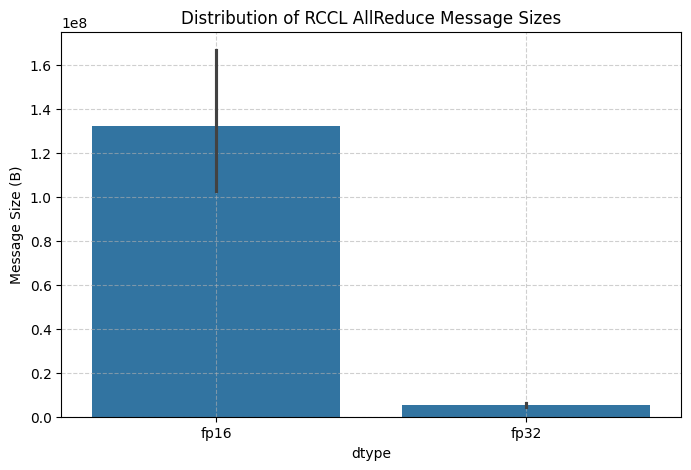

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV
# df = pd.read_csv("rccl_message_sizes.csv")
df = pd.read_csv("m.csv")

# Quick summary
print(df.head())
print("\nTotal rows:", len(df))
print("Datatypes present:", df["dtype"].unique())
# print(df.std())

# --- Plot 1: Boxplot of message sizes ---
plt.figure(figsize=(8, 5))
sns.barplot(x="dtype", y="size_bytes", data=df)
plt.ylabel("Message Size (B)")
plt.title("Distribution of RCCL AllReduce Message Sizes")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# # --- Plot 2: Scatter plot of size per task ---
# plt.figure(figsize=(10, 5))
# plt.scatter(df["Task"], df["Size_MB"], c="blue", alpha=0.6)
# plt.xlabel("Task ID")
# plt.ylabel("Message Size (MB)")
# plt.title("RCCL AllReduce Message Size per Task")
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.show()


In [ ]:
baseline type	time ms	percent
computation_time	1824.734723	93.36208472
exposed_comm_time	14.48978076	0.741365921
exposed_memcpy_time	103.1787734	5.279115515
busy_time	1942.403277	99.38256616
idle_time	12.06756445	0.617433844
total_time	1954.470842	100
total_comm_time	216.7280889	11.08883715
total_memcpy_time	103.3892363	5.289883794
		
		
nch16 type	time ms	percent
computation_time	1834.533548	92.68668539
exposed_comm_time	35.10423877	1.773581921
exposed_memcpy_time	98.00503662	4.951537685
busy_time	1967.642823	99.411805
idle_time	11.64205469	0.588195
total_time	1979.284878	100
total_comm_time	374.0931948	18.90042202
total_memcpy_time	109.0846206	5.51131481
